# Interpretabilidad y Explicabilidad de Modelos ML - Titanic Dataset

## Descripción
Este notebook analiza la interpretabilidad y explicabilidad de modelos de machine learning entrenados en el dataset del Titanic, utilizando técnicas como SHAP, LIME, Partial Dependence Plots y análisis de feature importance.

# Configuración Inicial

## Importación de Librerías

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings("ignore")

# Librerías para interpretabilidad
import shap
import lime
import lime.lime_tabular
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Configuración de visualización
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

## Clase de Preprocesamiento

In [19]:
class TitanicDatasetPreprocessor:
    def __init__(self):
        self.pipeline = None
        self.output_feature_names_ = None
        self.categorical_cols = ['Sex', 'Embarked', 'Pclass']
        self.numerical_cols = ['Age', 'SibSp', 'Parch', 'Fare']

    def fit(self, X, y=None):
        X_proc = X.copy()
        num_cols_pipeline = [c for c in self.numerical_cols if c in X_proc.columns]
        cat_cols_pipeline = [c for c in self.categorical_cols if c in X_proc.columns]

        num_transformer = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ])

        cat_transformer = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ])

        self.pipeline = ColumnTransformer(transformers=[
            ("num", num_transformer, num_cols_pipeline),
            ("cat", cat_transformer, cat_cols_pipeline)
        ], remainder='drop')

        X_proc_for_pipeline = X_proc[num_cols_pipeline + cat_cols_pipeline]
        self.pipeline.fit(X_proc_for_pipeline)

        self.output_feature_names_ = (
            num_cols_pipeline +
            list(self.pipeline.named_transformers_["cat"].named_steps["onehot"].get_feature_names_out(cat_cols_pipeline))
        )
        return self

    def transform(self, X):
        if self.pipeline is None:
            raise RuntimeError("Primero llama a fit() con los datos de entrenamiento.")

        X_proc = X.copy()
        num_cols_pipeline = [c for c in self.numerical_cols if c in X_proc.columns]
        cat_cols_pipeline = [c for c in self.categorical_cols if c in X_proc.columns]

        X_proc_for_pipeline = X_proc[num_cols_pipeline + cat_cols_pipeline]
        X_out = self.pipeline.transform(X_proc_for_pipeline)

        return pd.DataFrame(X_out, columns=self.output_feature_names_, index=X.index)

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

# Carga y Preparación de Datos

In [20]:
print("=== CARGANDO DATOS Y MODELOS ===")

# Cargar dataset procesado
df_fe = pd.read_csv("../data/processed/titanic_dataset_features.csv")
print(f"Dataset procesado cargado: {df_fe.shape}")

# Preparar datos para modelos
y = df_fe["Survived"]
X = df_fe.drop(columns=["Survived"])

# Preprocesar datos
preprocessor = TitanicDatasetPreprocessor()
X_transformed = preprocessor.fit_transform(X)

# Split de datos
X_train, X_test, y_train, y_test = train_test_split(
    X_transformed, y, test_size=0.2, random_state=42, stratify=y
)

# Aplicar imputación adicional
imputer = SimpleImputer(strategy='median')
X_train_imputed = pd.DataFrame(
    imputer.fit_transform(X_train), 
    columns=X_train.columns, 
    index=X_train.index
)
X_test_imputed = pd.DataFrame(
    imputer.transform(X_test), 
    columns=X_test.columns, 
    index=X_test.index
)

print(f"Datos preparados. X_train: {X_train_imputed.shape}, X_test: {X_test_imputed.shape}")

=== CARGANDO DATOS Y MODELOS ===
Dataset procesado cargado: (891, 23)
Datos preparados. X_train: (712, 12), X_test: (179, 12)


## Carga de Modelos Entrenados

In [21]:
# Cargar modelos entrenados
models = {}
model_files = {
    'Logistic Regression': '../models/logistic_regression_final.pkl',
    'Random Forest': '../models/random_forest_final.pkl',
    'Gradient Boosting': '../models/xgboost_final.pkl'
}

for name, filepath in model_files.items():
    with open(filepath, 'rb') as f:
        models[name] = pickle.load(f)
    print(f"Modelo {name} cargado exitosamente")

print(f"Modelos cargados: {list(models.keys())}")

Modelo Logistic Regression cargado exitosamente
Modelo Random Forest cargado exitosamente
Modelo Gradient Boosting cargado exitosamente
Modelos cargados: ['Logistic Regression', 'Random Forest', 'Gradient Boosting']


# Interpretabilidad Global

## Feature Importance Consolidada

In [22]:
print("="*60)
print("INTERPRETABILIDAD GLOBAL")
print("="*60)
print("\n--- FEATURE IMPORTANCE CONSOLIDADA ---")

feature_importance_comparison = pd.DataFrame()

for model_name, model in models.items():
    if hasattr(model, 'feature_importances_'):
        importance_values = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importance_values = np.abs(model.coef_[0])
    else:
        continue
    
    importance_df = pd.DataFrame({
        'feature': X_train_imputed.columns,
        f'{model_name}_importance': importance_values
    })
    
    if feature_importance_comparison.empty:
        feature_importance_comparison = importance_df
    else:
        feature_importance_comparison = feature_importance_comparison.merge(
            importance_df, on='feature', how='outer'
        )

# Calcular ranking promedio
importance_cols = [col for col in feature_importance_comparison.columns if 'importance' in col]
feature_importance_comparison['mean_importance'] = feature_importance_comparison[importance_cols].mean(axis=1)
feature_importance_comparison = feature_importance_comparison.sort_values('mean_importance', ascending=False)

print("\nRANKING CONSOLIDADO DE FEATURE IMPORTANCE:")
print(feature_importance_comparison.head(10))

INTERPRETABILIDAD GLOBAL

--- FEATURE IMPORTANCE CONSOLIDADA ---

RANKING CONSOLIDADO DE FEATURE IMPORTANCE:
       feature  Logistic Regression_importance  Random Forest_importance  \
9   Sex_female                        1.168503                  0.244156   
10    Sex_male                        0.934339                  0.135501   
8     Pclass_3                        0.643633                  0.063983   
6     Pclass_1                        0.716790                  0.039413   
0          Age                        0.376068                  0.179082   
4         Fare                        0.272092                  0.202411   
11       SibSp                        0.233620                  0.039085   
1   Embarked_C                        0.207229                  0.012832   
3   Embarked_S                        0.163819                  0.021121   
2   Embarked_Q                        0.190755                  0.009411   

    Gradient Boosting_importance  mean_importance  
9 

## Visualización de Feature Importance

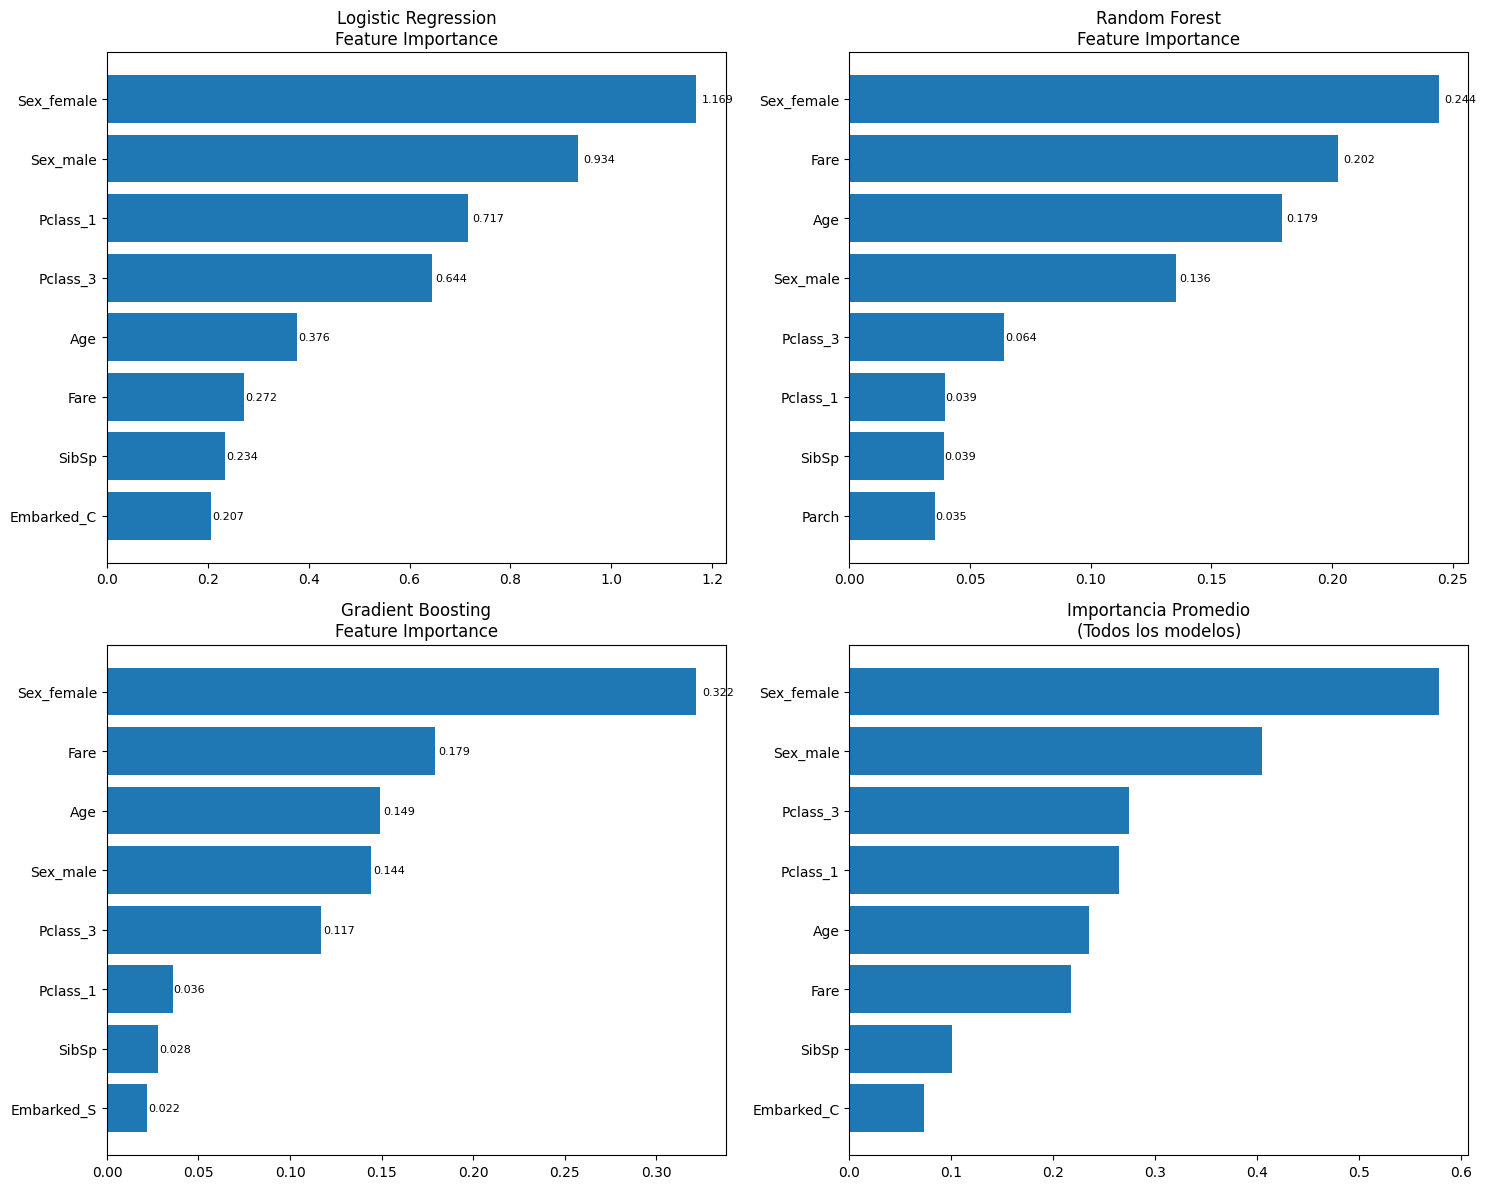


Top 5 features: ['Sex_female', 'Sex_male', 'Pclass_3', 'Pclass_1', 'Age']


In [23]:
# Visualización de feature importance
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

# Gráficos individuales de feature importance
for i, model_name in enumerate(['Logistic Regression', 'Random Forest', 'Gradient Boosting']):
    if i < 3:
        col_name = f'{model_name}_importance'
        if col_name in feature_importance_comparison.columns:
            top_features = feature_importance_comparison.nlargest(8, col_name)
            bars = axes[i].barh(range(len(top_features)), top_features[col_name])
            axes[i].set_yticks(range(len(top_features)))
            axes[i].set_yticklabels(top_features['feature'])
            axes[i].set_title(f'{model_name}\nFeature Importance')
            axes[i].invert_yaxis()
            
            # Añadir valores en las barras
            for j, bar in enumerate(bars):
                width = bar.get_width()
                axes[i].text(width + width*0.01, bar.get_y() + bar.get_height()/2, 
                           f'{width:.3f}', ha='left', va='center', fontsize=8)

# Comparación consolidada
top_features_overall = feature_importance_comparison.head(8)
axes[3].barh(range(len(top_features_overall)), top_features_overall['mean_importance'])
axes[3].set_yticks(range(len(top_features_overall)))
axes[3].set_yticklabels(top_features_overall['feature'])
axes[3].set_title('Importancia Promedio\n(Todos los modelos)')
axes[3].invert_yaxis()

plt.tight_layout()
plt.show()

# Top features para análisis posteriores
top_5_features = feature_importance_comparison.head(5)['feature'].tolist()
print(f"\nTop 5 features: {top_5_features}")

## Análisis SHAP Global


--- SHAP ANALYSIS GLOBAL ---

Análisis SHAP para Logistic Regression
SHAP values calculados: (50, 12)


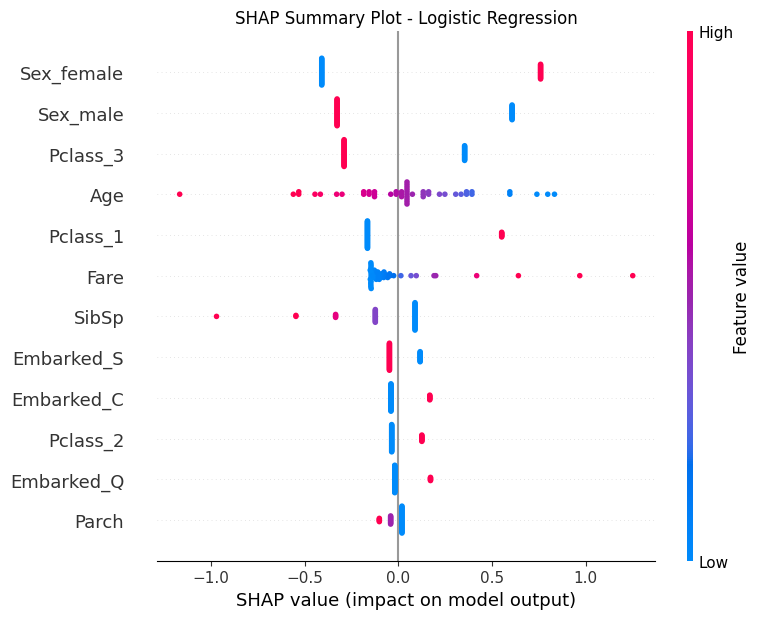

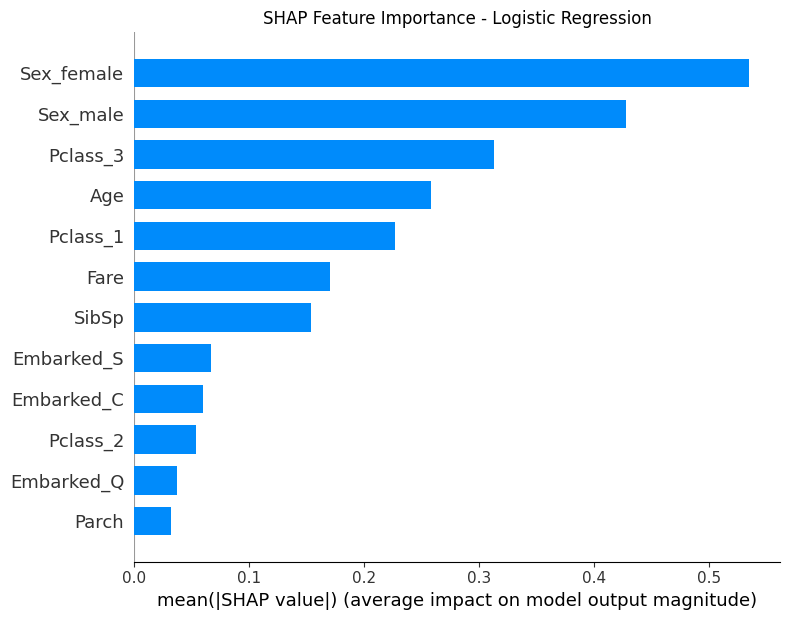

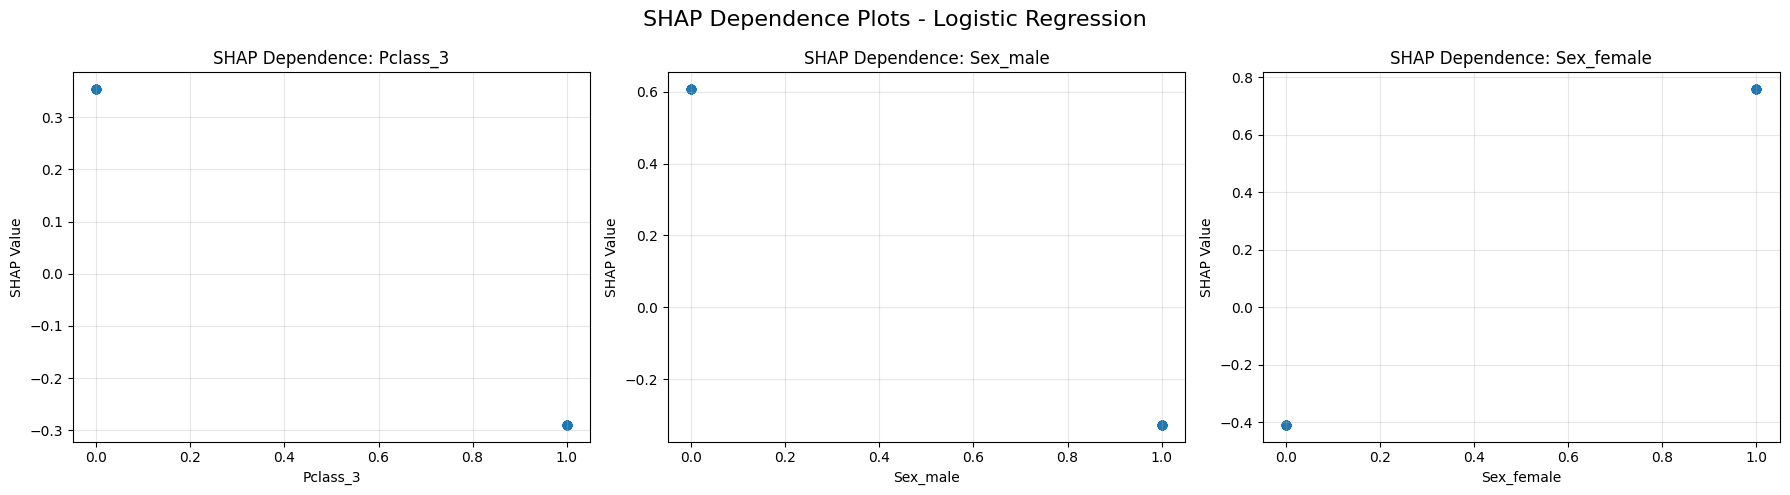

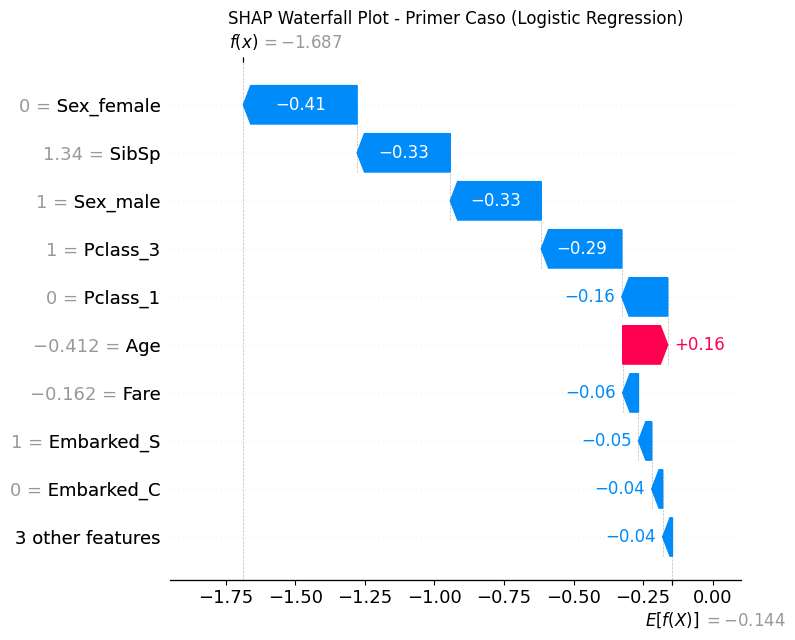


Análisis SHAP para Random Forest
SHAP values calculados: (50, 12, 2)


<Figure size 1000x800 with 0 Axes>

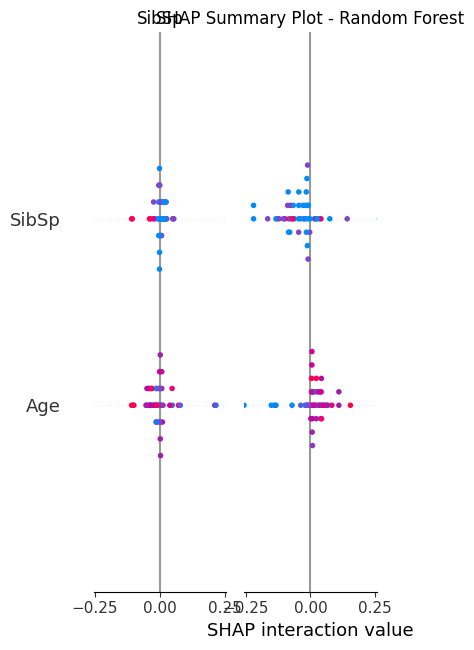

<Figure size 1000x600 with 0 Axes>

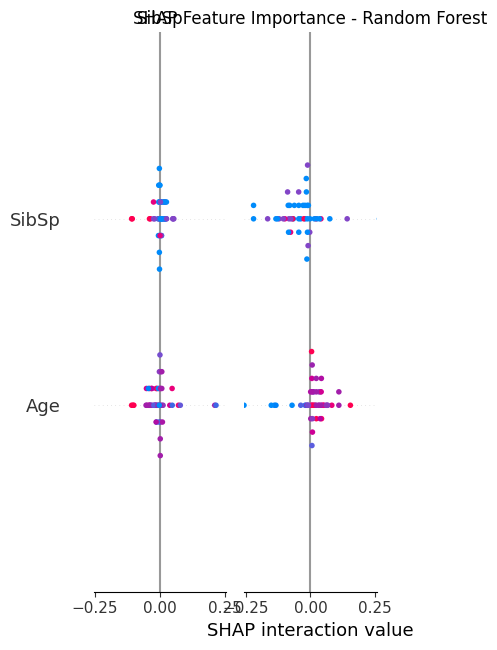

Error en análisis SHAP: x and y must be the same size

Análisis SHAP para Gradient Boosting
SHAP values calculados: (50, 12)


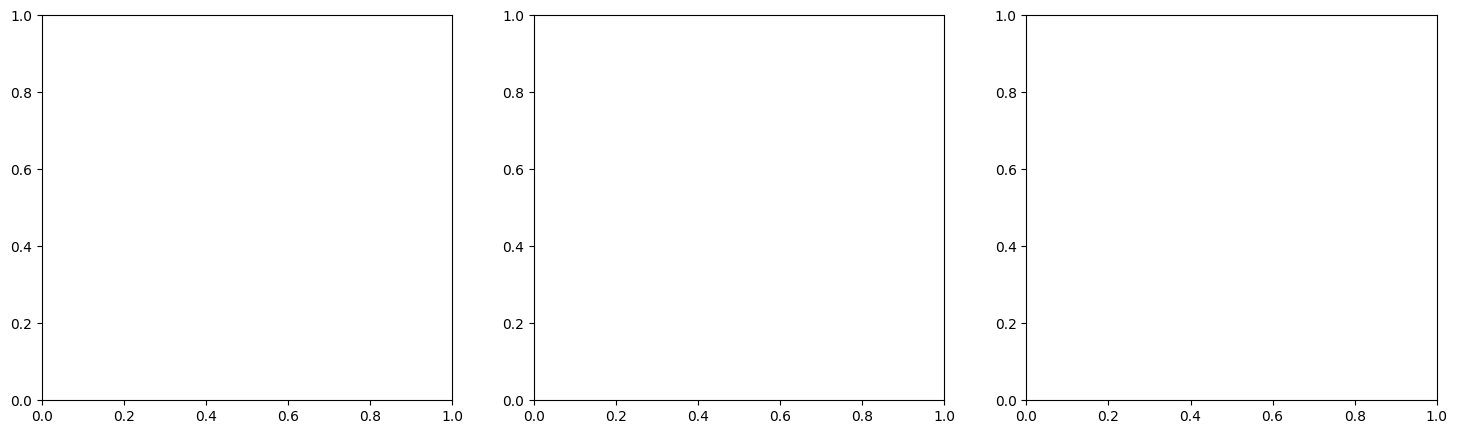

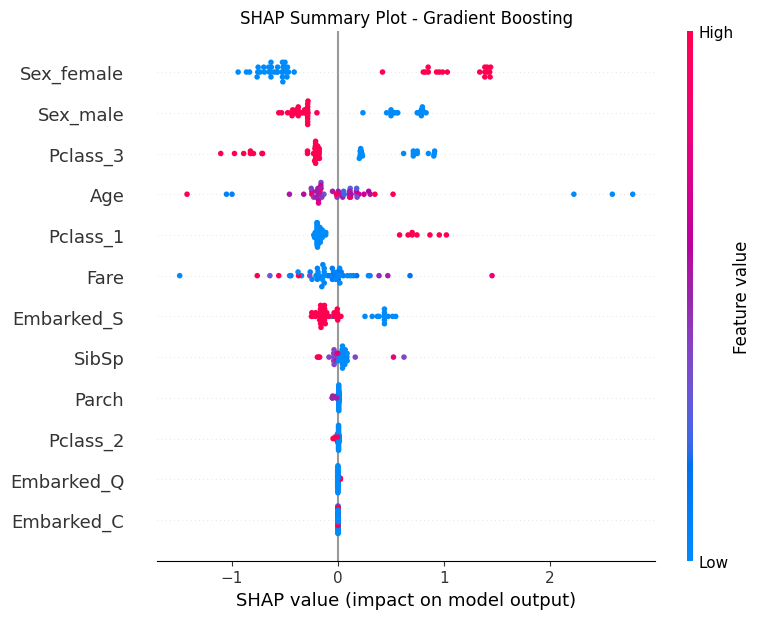

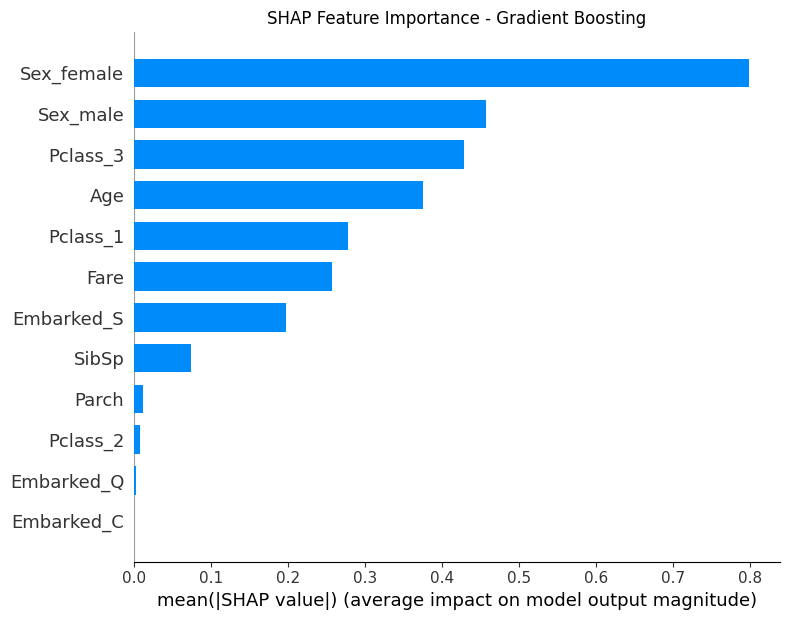

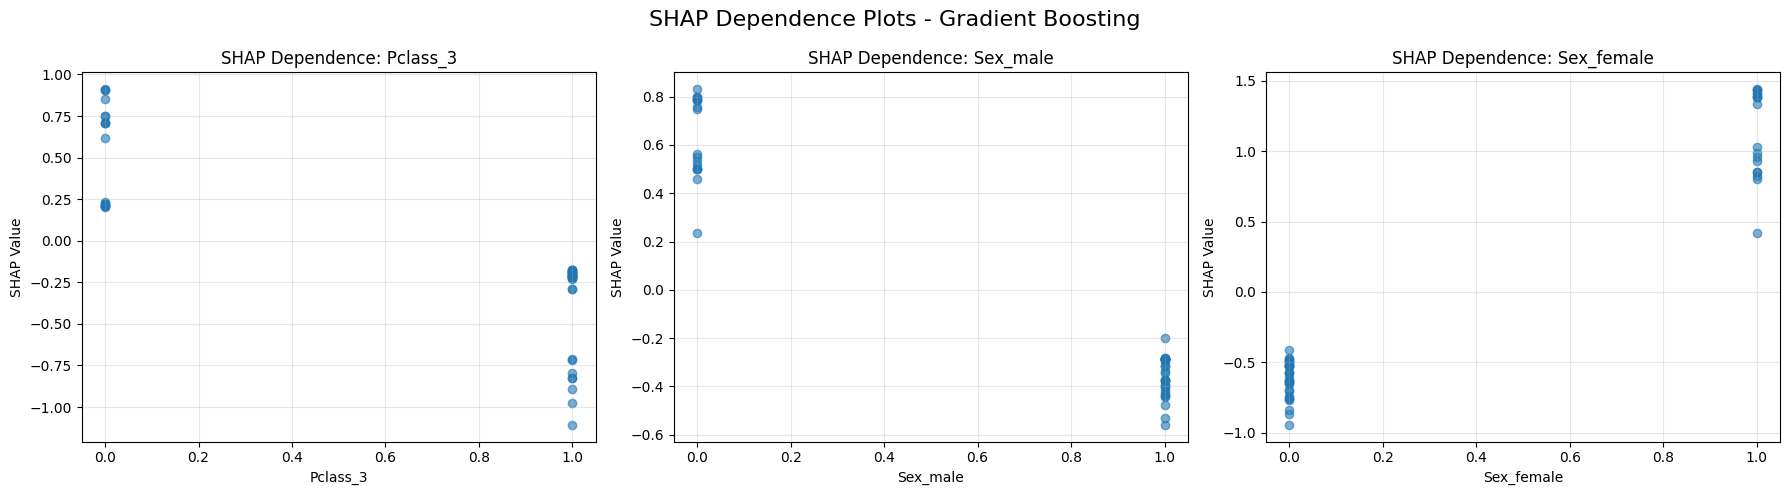

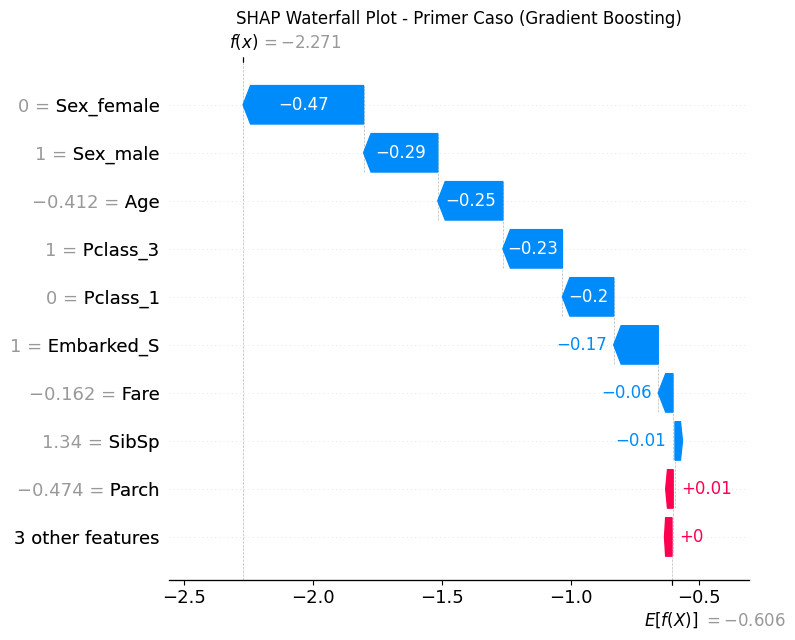

In [24]:
print("\n--- SHAP ANALYSIS GLOBAL ---")

def shap_analysis_improved(model, model_name, X_train_data, X_test_data, sample_size=50):
    """Análisis SHAP mejorado con mejor manejo de errores"""
    print(f"\nAnálisis SHAP para {model_name}")
    
    try:
        # Usar muestra más pequeña para eficiencia
        X_sample = X_test_data.iloc[:sample_size].copy()
        X_background = X_train_data.iloc[:min(100, len(X_train_data))].copy()
        
        # Seleccionar explainer apropiado
        if hasattr(model, 'feature_importances_'):
            # Tree-based models
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_sample)
            
            # Manejar formato de salida para clasificación binaria
            if isinstance(shap_values, list) and len(shap_values) == 2:
                shap_values = shap_values[1]  # Clase positiva
                expected_value = explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value
            else:
                expected_value = explainer.expected_value
                
        elif hasattr(model, 'coef_'):
            # Linear models
            explainer = shap.LinearExplainer(model, X_background)
            shap_values = explainer.shap_values(X_sample)
            expected_value = explainer.expected_value
        else:
            # Fallback to KernelExplainer
            def predict_fn(X):
                return model.predict_proba(X)[:, 1]
            
            explainer = shap.KernelExplainer(predict_fn, X_background.iloc[:20])
            shap_values = explainer.shap_values(X_sample.iloc[:20])
            expected_value = explainer.expected_value
            X_sample = X_sample.iloc[:20]
        
        print(f"SHAP values calculados: {shap_values.shape}")
        
        # Verificar dimensiones
        if shap_values.shape[1] != X_sample.shape[1]:
            print(f"Error de dimensiones: SHAP {shap_values.shape} vs Features {X_sample.shape}")
            return None, None
        
        # 1. SHAP Summary Plot
        plt.figure(figsize=(10, 8))
        try:
            shap.summary_plot(shap_values, X_sample, plot_type="dot", show=False)
            plt.title(f'SHAP Summary Plot - {model_name}')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error en summary plot: {e}")
        
        # 2. SHAP Feature Importance
        plt.figure(figsize=(10, 6))
        try:
            shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
            plt.title(f'SHAP Feature Importance - {model_name}')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error en bar plot: {e}")
        
        # 3. SHAP Dependence Plots
        feature_importance_shap = np.abs(shap_values).mean(0)
        top_3_indices = np.argsort(feature_importance_shap)[-3:]
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        for i, idx in enumerate(top_3_indices):
            feature_name = X_sample.columns[idx]
            try:
                shap.plots.scatter(
                    shap_values[:, idx], 
                    X_sample.iloc[:, idx], 
                    ax=axes[i],
                    show=False
                )
                axes[i].set_title(f'SHAP Dependence: {feature_name}')
                axes[i].set_xlabel(feature_name)
                axes[i].set_ylabel('SHAP Value')
            except Exception as e:
                # Método manual como fallback
                axes[i].scatter(X_sample.iloc[:, idx], shap_values[:, idx], alpha=0.6)
                axes[i].set_xlabel(feature_name)
                axes[i].set_ylabel('SHAP Value')
                axes[i].set_title(f'SHAP Dependence: {feature_name}')
                axes[i].grid(True, alpha=0.3)
        
        plt.suptitle(f'SHAP Dependence Plots - {model_name}', fontsize=16)
        plt.tight_layout()
        plt.show()
        
        # 4. SHAP Waterfall Plot para un caso específico
        try:
            if len(shap_values) > 0:
                plt.figure(figsize=(10, 6))
                
                explanation = shap.Explanation(
                    values=shap_values[0], 
                    base_values=expected_value,
                    data=X_sample.iloc[0].values,
                    feature_names=X_sample.columns.tolist()
                )
                
                shap.plots.waterfall(explanation, show=False)
                plt.title(f'SHAP Waterfall Plot - Primer Caso ({model_name})')
                plt.tight_layout()
                plt.show()
        except Exception as e:
            print(f"No se pudo generar waterfall plot: {e}")
        
        return shap_values, explainer
        
    except Exception as e:
        print(f"Error en análisis SHAP: {e}")
        return None, None

# Realizar análisis SHAP para cada modelo
shap_results = {}
for model_name, model in models.items():
    shap_values, explainer = shap_analysis_improved(model, model_name, X_train_imputed, X_test_imputed)
    if shap_values is not None:
        shap_results[model_name] = {'values': shap_values, 'explainer': explainer}

## Partial Dependence Plots


--- PARTIAL DEPENDENCE PLOTS ---

PDPs para Logistic Regression


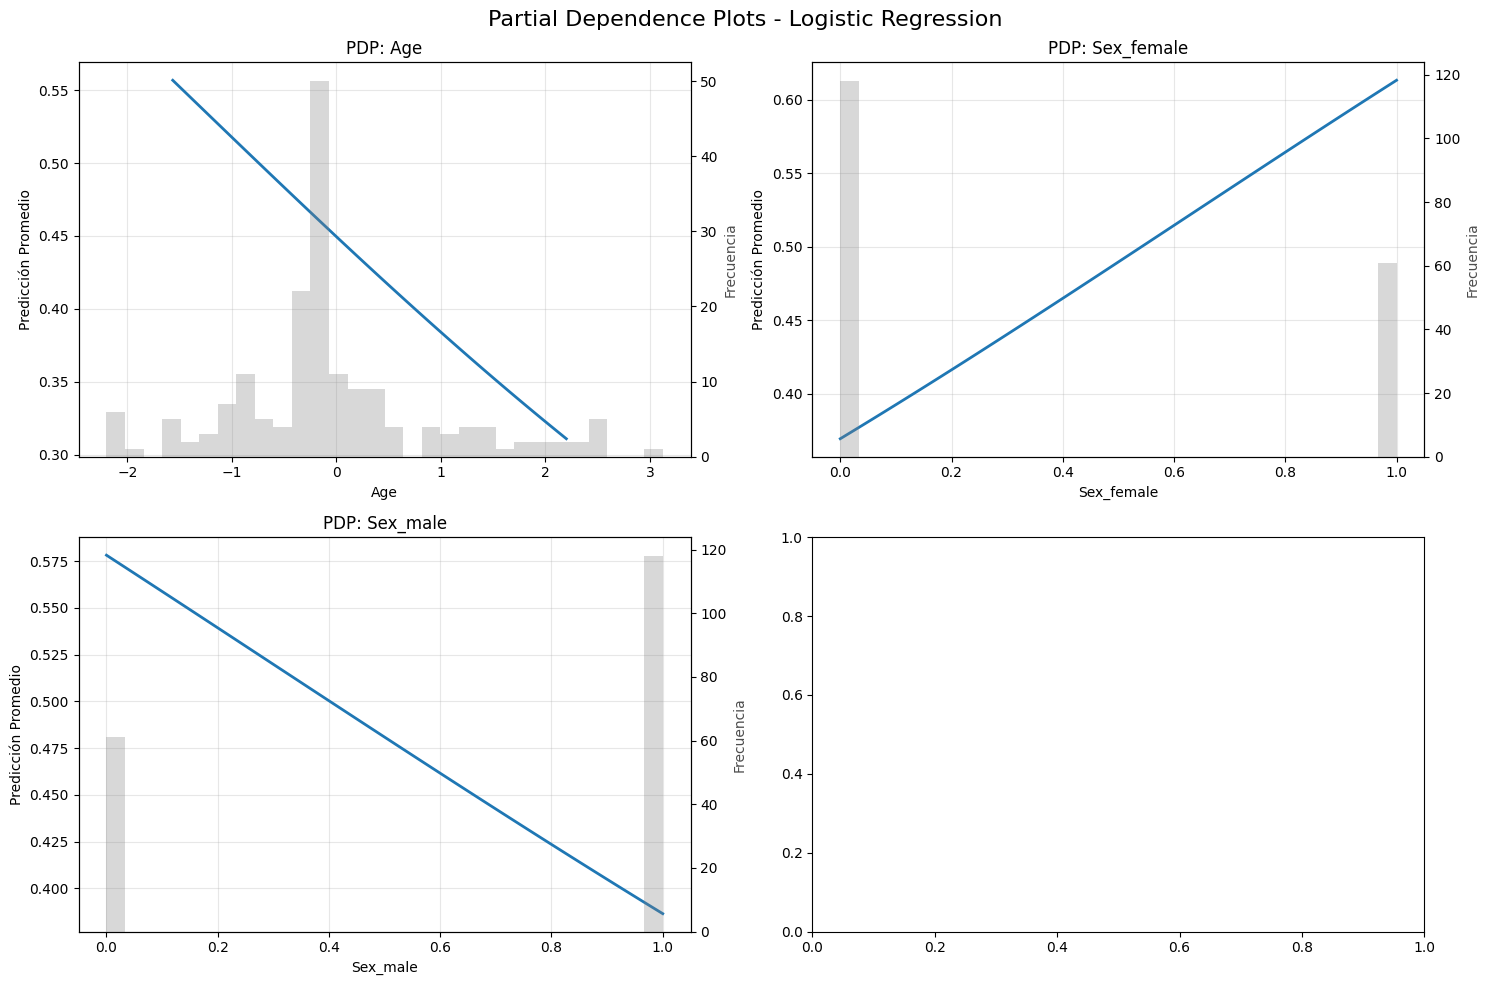

In [25]:
print("\n--- PARTIAL DEPENDENCE PLOTS ---")

def plot_pdp_improved(model, model_name, X_data, top_features):
    """PDPs mejorados con mejor manejo de errores"""
    print(f"\nPDPs para {model_name}")
    
    # Filtrar features apropiadas
    numeric_features = []
    categorical_features = []
    
    for feature in top_features:
        if feature in X_data.columns:
            unique_vals = X_data[feature].nunique()
            if unique_vals > 10:  # Numérica continua
                numeric_features.append(feature)
            elif unique_vals <= 5:  # Categórica
                categorical_features.append(feature)
    
    # Tomar hasta 4 features numéricas
    features_to_plot = numeric_features[:4]
    if len(features_to_plot) < 2:
        features_to_plot.extend(categorical_features[:2])
    
    if len(features_to_plot) >= 2:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()
        
        # PDPs individuales
        for i, feature in enumerate(features_to_plot[:4]):
            try:
                feature_idx = X_data.columns.get_loc(feature)
                
                # Calcular PDP manualmente para más control
                feature_values = np.linspace(
                    X_data[feature].quantile(0.05), 
                    X_data[feature].quantile(0.95), 
                    50
                )
                
                pdp_values = []
                for val in feature_values:
                    X_temp = X_data.copy()
                    X_temp[feature] = val
                    if hasattr(model, 'predict_proba'):
                        pred_mean = model.predict_proba(X_temp)[:, 1].mean()
                    else:
                        pred_mean = model.predict(X_temp).mean()
                    pdp_values.append(pred_mean)
                
                axes[i].plot(feature_values, pdp_values, linewidth=2)
                axes[i].set_xlabel(feature)
                axes[i].set_ylabel('Predicción Promedio')
                axes[i].set_title(f'PDP: {feature}')
                axes[i].grid(True, alpha=0.3)
                
                # Agregar histograma de la distribución
                ax_twin = axes[i].twinx()
                ax_twin.hist(X_data[feature], bins=30, alpha=0.3, color='gray')
                ax_twin.set_ylabel('Frecuencia', alpha=0.7)
                
            except Exception as e:
                axes[i].text(0.5, 0.5, f'Error: {feature}', 
                           ha='center', va='center', transform=axes[i].transAxes)
                print(f"Error en PDP para {feature}: {e}")
        
        plt.suptitle(f'Partial Dependence Plots - {model_name}', fontsize=16)
        plt.tight_layout()
        plt.show()

# Generar PDPs para el mejor modelo
best_model_name = list(models.keys())[0]
best_model = models[best_model_name]
plot_pdp_improved(best_model, best_model_name, X_test_imputed, top_5_features)

# Interpretabilidad Local

INTERPRETABILIDAD LOCAL

--- ANÁLISIS DE CASOS REPRESENTATIVOS ---
Casos seleccionados para análisis: [np.int64(25), np.int64(3), np.int64(4), np.int64(14), np.int64(2)]

ANÁLISIS DETALLADO - CASO #25
--------------------------------------------------
Información del Caso:
  • Etiqueta real: Sobrevive
  • Predicción: Sobrevive
  • Probabilidad: 0.944
  • Resultado: Correcto

Features más significativas:
   1. Pclass_1       :  1.000
   2. Embarked_C     :  1.000
   3. Sex_female     :  1.000
   4. Fare           :  0.747
   5. SibSp          : -0.475
   6. Parch          : -0.474
   7. Age            : -0.412

Explicación LIME:
    Aumenta supervivencia: 0.00 < Sex_female <= 1.00 (+0.248)
    Aumenta supervivencia: Sex_male <= 0.00 (+0.190)
    Aumenta supervivencia: Pclass_1 > 0.00 (+0.144)
    Aumenta supervivencia: Pclass_3 <= 0.00 (+0.130)
    Aumenta supervivencia: Fare > -0.02 (+0.125)
    Reduce supervivencia: Embarked_Q <= 0.00 (-0.040)
    Reduce supervivencia: Pclass_2 <= 0.0

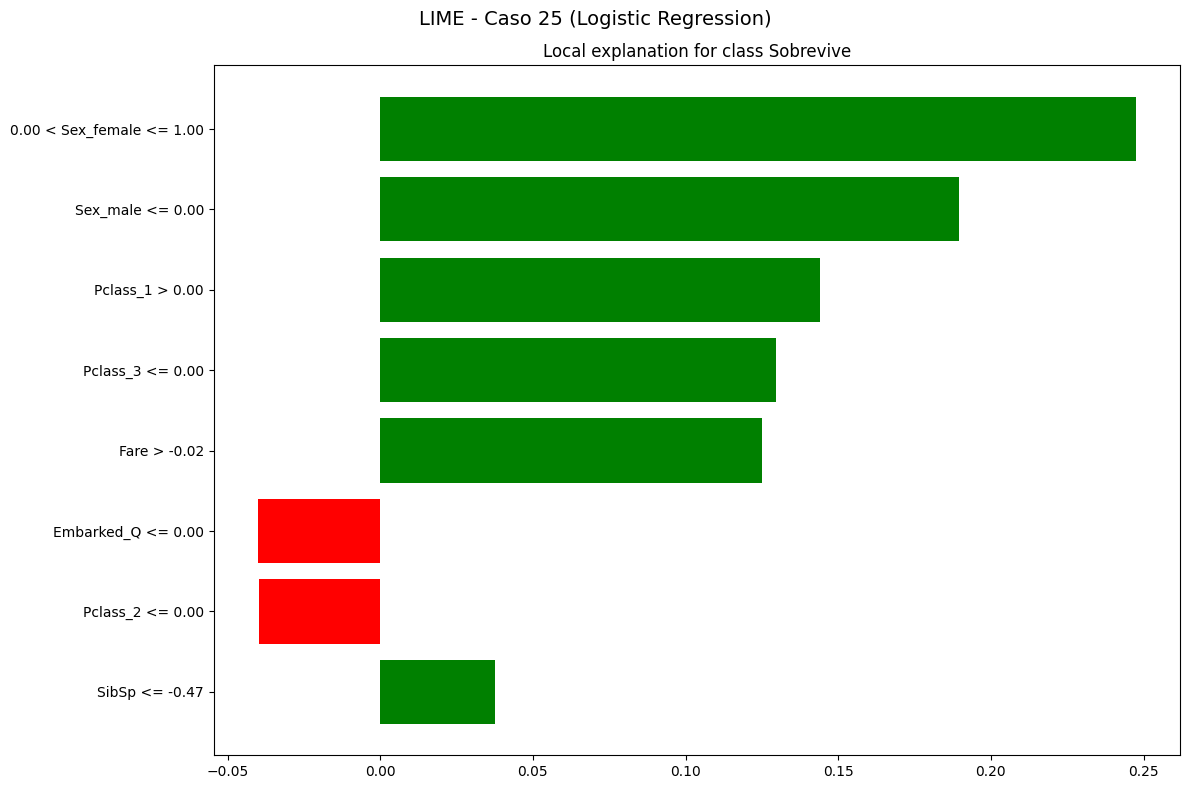


Contribución SHAP:
    ↑ Sex_female: +0.760
    ↑ Sex_male: +0.607
    ↑ Pclass_1: +0.552
    ↑ Pclass_3: +0.354
    ↑ Fare: +0.191
    ↑ Embarked_C: +0.168

ANÁLISIS DETALLADO - CASO #3
--------------------------------------------------
Información del Caso:
  • Etiqueta real: No sobrevive
  • Predicción: No sobrevive
  • Probabilidad: 0.097
  • Resultado: Correcto

Features más significativas:
   1. SibSp          :  1.340
   2. Embarked_S     :  1.000
   3. Sex_male       :  1.000
   4. Pclass_3       :  1.000
   5. Age            :  0.894
   6. Parch          : -0.474
   7. Fare           : -0.364

Explicación LIME:
    Reduce supervivencia: Sex_female <= 0.00 (-0.246)
    Reduce supervivencia: 0.00 < Sex_male <= 1.00 (-0.197)
    Reduce supervivencia: Pclass_1 <= 0.00 (-0.147)
    Reduce supervivencia: Age > 0.51 (-0.138)
    Reduce supervivencia: 0.00 < Pclass_3 <= 1.00 (-0.127)
    Reduce supervivencia: SibSp > 0.43 (-0.096)
    Reduce supervivencia: -0.49 < Fare <= -0.36 (-0.0

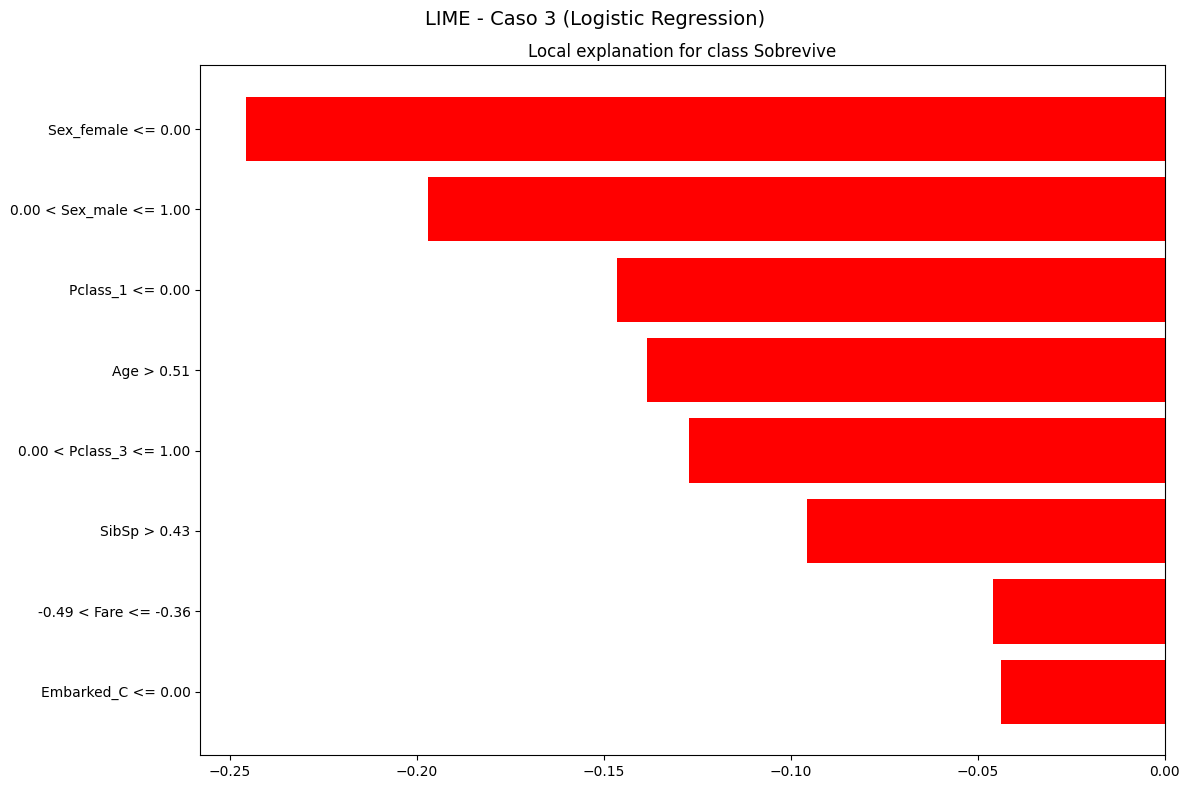


Contribución SHAP:
    ↓ Sex_female: -0.409
    ↓ SibSp: -0.335
    ↓ Age: -0.329
    ↓ Sex_male: -0.327
    ↓ Pclass_3: -0.290
    ↓ Pclass_1: -0.165

ANÁLISIS DETALLADO - CASO #4
--------------------------------------------------
Información del Caso:
  • Etiqueta real: Sobrevive
  • Predicción: Sobrevive
  • Probabilidad: 0.694
  • Resultado: Correcto

Features más significativas:
   1. Pclass_3       :  1.000
   2. Embarked_Q     :  1.000
   3. Sex_female     :  1.000
   4. Parch          : -0.474
   5. SibSp          :  0.433
   6. Fare           : -0.336
   7. Age            : -0.105

Explicación LIME:
    Aumenta supervivencia: 0.00 < Sex_female <= 1.00 (+0.243)
    Aumenta supervivencia: Sex_male <= 0.00 (+0.194)
    Reduce supervivencia: Pclass_1 <= 0.00 (-0.154)
    Reduce supervivencia: 0.00 < Pclass_3 <= 1.00 (-0.118)
    Reduce supervivencia: Embarked_C <= 0.00 (-0.062)
    Aumenta supervivencia: Embarked_Q > 0.00 (+0.048)
    Aumenta supervivencia: Embarked_S <= 0.00 (+0

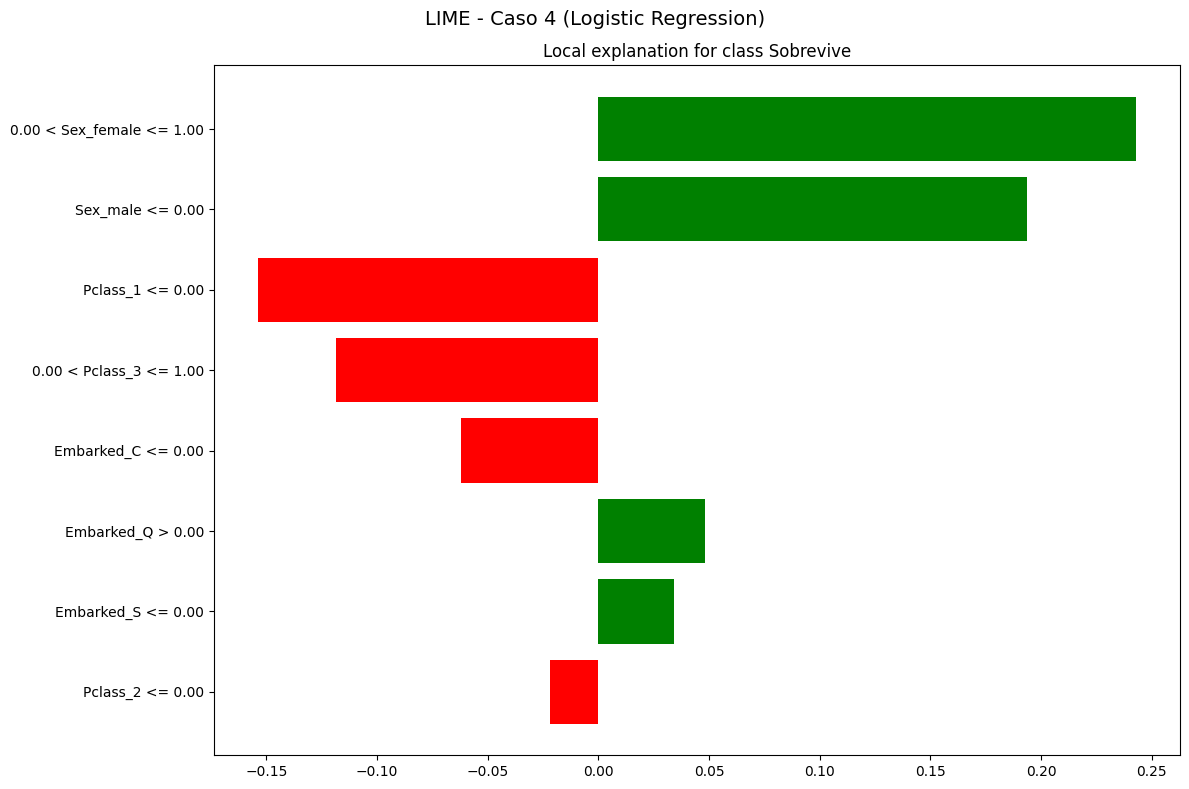


Contribución SHAP:
    ↑ Sex_female: +0.760
    ↑ Sex_male: +0.607
    ↓ Pclass_3: -0.290
    ↑ Embarked_Q: +0.172
    ↓ Pclass_1: -0.165
    ↓ SibSp: -0.123

ANÁLISIS DETALLADO - CASO #14
--------------------------------------------------
Información del Caso:
  • Etiqueta real: No sobrevive
  • Predicción: Sobrevive
  • Probabilidad: 0.689
  • Resultado: Incorrecto

Features más significativas:
   1. Fare           :  4.647
   2. SibSp          :  2.247
   3. Parch          :  2.009
   4. Embarked_S     :  1.000
   5. Sex_male       :  1.000
   6. Pclass_1       :  1.000
   7. Age            : -0.796

Explicación LIME:
    Reduce supervivencia: Sex_female <= 0.00 (-0.253)
    Reduce supervivencia: 0.00 < Sex_male <= 1.00 (-0.199)
    Aumenta supervivencia: Pclass_1 > 0.00 (+0.154)
    Reduce supervivencia: SibSp > 0.43 (-0.133)
    Aumenta supervivencia: Pclass_3 <= 0.00 (+0.129)
    Aumenta supervivencia: Fare > -0.02 (+0.124)
    Aumenta supervivencia: Age <= -0.57 (+0.123)
    Re

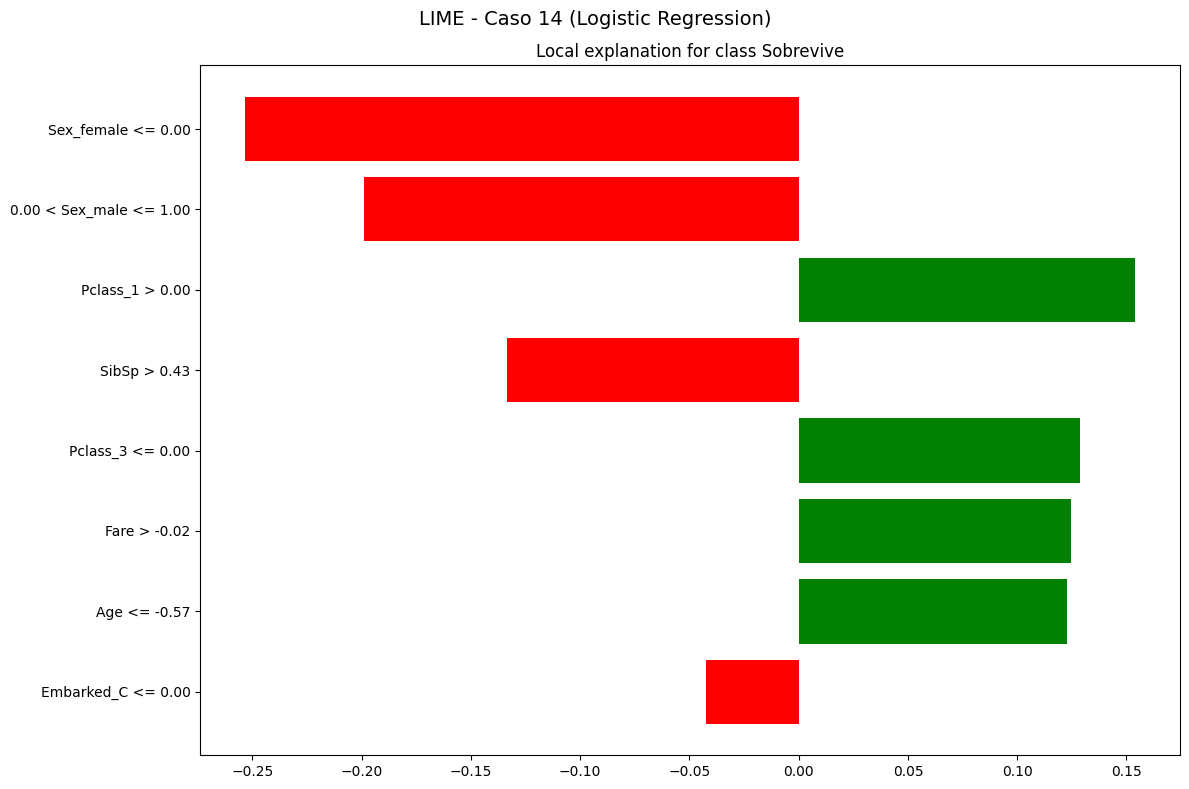


Contribución SHAP:
    ↑ Fare: +1.252
    ↑ Pclass_1: +0.552
    ↓ SibSp: -0.547
    ↓ Sex_female: -0.409
    ↑ Pclass_3: +0.354
    ↓ Sex_male: -0.327

ANÁLISIS DETALLADO - CASO #2
--------------------------------------------------
Información del Caso:
  • Etiqueta real: Sobrevive
  • Predicción: No sobrevive
  • Probabilidad: 0.284
  • Resultado: Incorrecto

Features más significativas:
   1. Pclass_3       :  1.000
   2. Embarked_C     :  1.000
   3. Sex_male       :  1.000
   4. Age            : -0.566
   5. Fare           : -0.503
   6. SibSp          : -0.475
   7. Parch          : -0.474

Explicación LIME:
    Reduce supervivencia: Sex_female <= 0.00 (-0.247)
    Reduce supervivencia: 0.00 < Sex_male <= 1.00 (-0.188)
    Reduce supervivencia: Pclass_1 <= 0.00 (-0.142)
    Aumenta supervivencia: Age <= -0.57 (+0.141)
    Reduce supervivencia: 0.00 < Pclass_3 <= 1.00 (-0.131)
    Reduce supervivencia: Embarked_Q <= 0.00 (-0.047)
    Aumenta supervivencia: SibSp <= -0.47 (+0.044)

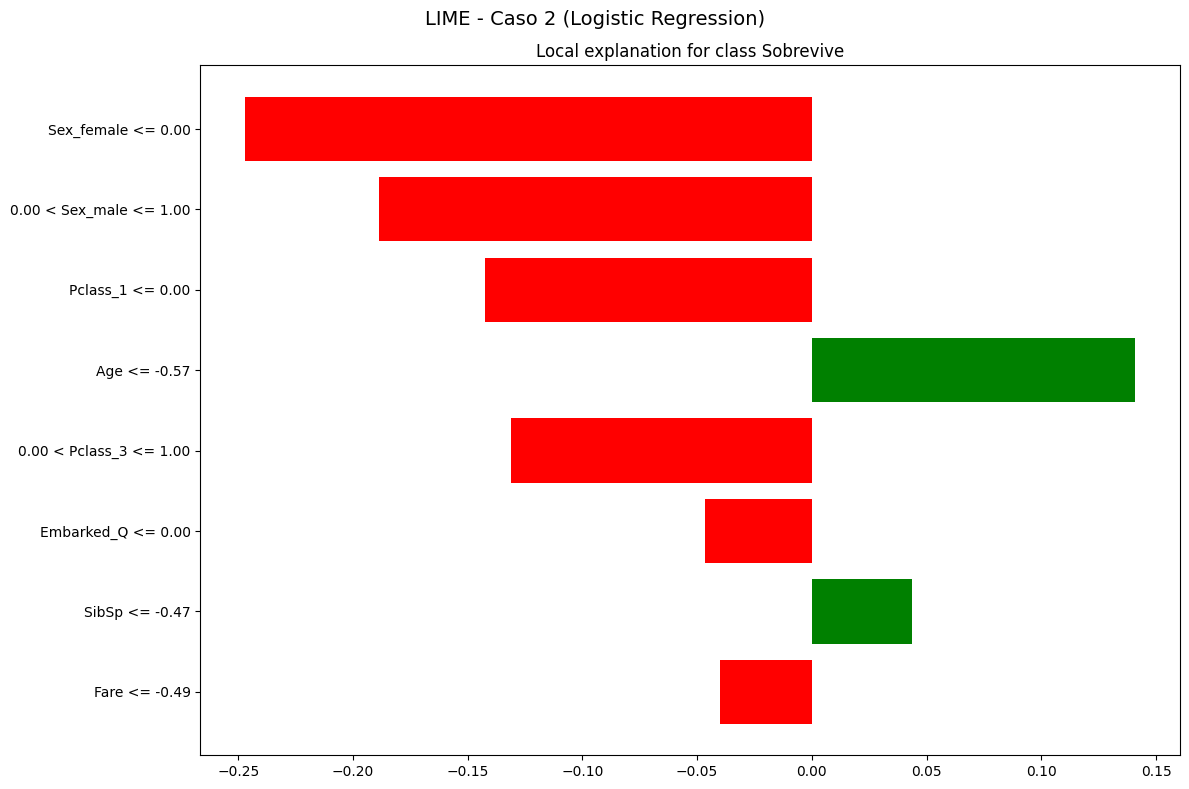


Contribución SHAP:
    ↓ Sex_female: -0.409
    ↓ Sex_male: -0.327
    ↓ Pclass_3: -0.290
    ↑ Age: +0.220
    ↑ Embarked_C: +0.168
    ↓ Pclass_1: -0.165


In [26]:
print("="*60)
print("INTERPRETABILIDAD LOCAL")
print("="*60)

def select_interesting_cases(X_test, y_test, model, n_cases=5):
    """Seleccionar casos interesantes para análisis local"""
    
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    cases = []
    
    # 1. Caso con alta confianza correcta (superviviente)
    high_conf_survivor = np.where(
        (y_pred == 1) & (y_test == 1) & (y_proba > 0.9)
    )[0]
    if len(high_conf_survivor) > 0:
        cases.append(high_conf_survivor[0])
    
    # 2. Caso con alta confianza correcta (no superviviente)
    high_conf_dead = np.where(
        (y_pred == 0) & (y_test == 0) & (y_proba < 0.1)
    )[0]
    if len(high_conf_dead) > 0:
        cases.append(high_conf_dead[0])
    
    # 3. Caso con baja confianza
    low_conf = np.where(np.abs(y_proba - 0.5) < 0.2)[0]
    if len(low_conf) > 0:
        cases.append(low_conf[0])
    
    # 4. Falso positivo
    false_pos = np.where((y_pred == 1) & (y_test == 0))[0]
    if len(false_pos) > 0:
        cases.append(false_pos[0])
    
    # 5. Falso negativo
    false_neg = np.where((y_pred == 0) & (y_test == 1))[0]
    if len(false_neg) > 0:
        cases.append(false_neg[0])
    
    return cases[:n_cases]

def explain_case_detailed(case_idx, model, model_name, X_train, X_test, y_test):
    """Explicación detallada de un caso específico"""
    
    print(f"\nANÁLISIS DETALLADO - CASO #{case_idx}")
    print("-" * 50)
    
    # Información básica del caso
    case_data = X_test.iloc[case_idx]
    true_label = y_test.iloc[case_idx]
    pred_label = model.predict([case_data])[0]
    pred_proba = model.predict_proba([case_data])[0, 1]
    
    print(f"Información del Caso:")
    print(f"  • Etiqueta real: {'Sobrevive' if true_label else 'No sobrevive'}")
    print(f"  • Predicción: {'Sobrevive' if pred_label else 'No sobrevive'}")
    print(f"  • Probabilidad: {pred_proba:.3f}")
    print(f"  • Resultado: {'Correcto' if pred_label == true_label else 'Incorrecto'}")
    
    # Características más relevantes
    print(f"\nFeatures más significativas:")
    significant_features = case_data[case_data.abs() > 0.1].sort_values(key=abs, ascending=False)
    for i, (feature, value) in enumerate(significant_features.head(8).items()):
        print(f"  {i+1:2d}. {feature:15s}: {value:6.3f}")
    
    # LIME Explanation mejorada
    try:
        print(f"\nExplicación LIME:")
        
        lime_explainer = lime.lime_tabular.LimeTabularExplainer(
            training_data=np.array(X_train),
            feature_names=X_train.columns,
            class_names=['No Sobrevive', 'Sobrevive'],
            mode='classification',
            discretize_continuous=True
        )
        
        lime_exp = lime_explainer.explain_instance(
            data_row=case_data.values,
            predict_fn=model.predict_proba,
            num_features=8,
            num_samples=1000
        )
        
        # Mostrar explicación en texto
        for feature, weight in lime_exp.as_list():
            direction = "Aumenta" if weight > 0 else "Reduce"
            print(f"    {direction} supervivencia: {feature} ({weight:+.3f})")
        
        # Visualizar LIME
        fig = lime_exp.as_pyplot_figure()
        fig.suptitle(f'LIME - Caso {case_idx} ({model_name})', fontsize=14)
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error en LIME: {e}")
    
    # SHAP para este caso específico (si disponible)
    if model_name in shap_results:
        try:
            print(f"\nContribución SHAP:")
            shap_values = shap_results[model_name]['values']
            
            # Encontrar el índice correspondiente en los datos de SHAP
            if case_idx < len(shap_values):
                case_shap = shap_values[case_idx]
                feature_contributions = list(zip(X_test.columns, case_shap))
                feature_contributions.sort(key=lambda x: abs(x[1]), reverse=True)
                
                for feature, contribution in feature_contributions[:6]:
                    direction = "↑" if contribution > 0 else "↓"
                    print(f"    {direction} {feature}: {contribution:+.3f}")
            
        except Exception as e:
            print(f"Error en SHAP local: {e}")

# Análisis de casos seleccionados
print("\n--- ANÁLISIS DE CASOS REPRESENTATIVOS ---")

selected_cases = select_interesting_cases(X_test_imputed, y_test, best_model)
print(f"Casos seleccionados para análisis: {selected_cases}")

for case_idx in selected_cases:
    explain_case_detailed(case_idx, best_model, best_model_name, 
                         X_train_imputed, X_test_imputed, y_test)

# Análisis de Estabilidad de Explicaciones

In [27]:
def analyze_explanation_stability(model, X_sample, n_iterations=5):
    """Analizar estabilidad de explicaciones LIME"""
    print("\nANÁLISIS DE ESTABILIDAD DE EXPLICACIONES LIME")
    
    case_idx = 0  # Primer caso como ejemplo
    case_data = X_sample.iloc[case_idx]
    
    lime_explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=np.array(X_sample),
        feature_names=X_sample.columns,
        class_names=['No Sobrevive', 'Sobrevive'],
        mode='classification'
    )
    
    stability_results = []
    
    for i in range(n_iterations):
        try:
            lime_exp = lime_explainer.explain_instance(
                data_row=case_data.values,
                predict_fn=model.predict_proba,
                num_features=5,
                num_samples=500
            )
            
            # Extraer pesos de las features
            feature_weights = dict(lime_exp.as_list())
            stability_results.append(feature_weights)
            
        except Exception as e:
            print(f"Error en iteración {i+1}: {e}")
    
    if stability_results:
        # Calcular estadísticas de estabilidad
        all_features = set()
        for result in stability_results:
            all_features.update(result.keys())
        
        stability_stats = {}
        for feature in all_features:
            weights = [result.get(feature, 0) for result in stability_results]
            stability_stats[feature] = {
                'mean': np.mean(weights),
                'std': np.std(weights),
                'cv': np.std(weights) / (abs(np.mean(weights)) + 1e-8)  # Coeficiente de variación
            }
        
        print(f"\nESTABILIDAD DE EXPLICACIONES (n={len(stability_results)}):")
        sorted_features = sorted(stability_stats.items(), 
                               key=lambda x: abs(x[1]['mean']), reverse=True)
        
        for feature, stats in sorted_features[:8]:
            stability_level = "Estable" if stats['cv'] < 0.3 else "Moderada" if stats['cv'] < 0.8 else "Inestable"
            print(f"  {feature:20s}: {stats['mean']:+.3f} ± {stats['std']:.3f} | {stability_level}")

# Ejecutar análisis de estabilidad
if len(X_test_imputed) > 10:
    analyze_explanation_stability(best_model, X_test_imputed.head(20))


ANÁLISIS DE ESTABILIDAD DE EXPLICACIONES LIME

ESTABILIDAD DE EXPLICACIONES (n=5):
  Sex_female <= 0.00  : -0.251 ± 0.008 | Estable
  0.00 < Sex_male <= 1.00: -0.196 ± 0.006 | Estable
  Pclass_1 <= 0.00    : -0.151 ± 0.007 | Estable
  0.00 < Pclass_3 <= 1.00: -0.132 ± 0.005 | Estable
  Age <= -0.35        : +0.074 ± 0.011 | Estable


# Análisis de Interacciones entre Features

In [28]:
print("\nANÁLISIS DE INTERACCIONES ENTRE FEATURES")

def analyze_feature_interactions(model, X_data, top_features):
    """Analizar interacciones entre features importantes"""
    
    interaction_effects = []
    
    # Probar combinaciones de los top features
    for i in range(min(3, len(top_features))):
        for j in range(i+1, min(4, len(top_features))):
            feature1, feature2 = top_features[i], top_features[j]
            
            if feature1 in X_data.columns and feature2 in X_data.columns:
                try:
                    # Crear grid de valores para evaluar interacción
                    n_points = 10
                    f1_range = np.linspace(X_data[feature1].quantile(0.1), 
                                         X_data[feature1].quantile(0.9), n_points)
                    f2_range = np.linspace(X_data[feature2].quantile(0.1), 
                                         X_data[feature2].quantile(0.9), n_points)
                    
                    # Evaluar efecto de interacción
                    base_case = X_data.median()
                    interaction_strength = 0
                    
                    for f1_val in f1_range[::3]:  # Samplear para eficiencia
                        for f2_val in f2_range[::3]:
                            # Caso con ambas features
                            case_both = base_case.copy()
                            case_both[feature1] = f1_val
                            case_both[feature2] = f2_val
                            pred_both = model.predict_proba([case_both])[0, 1]
                            
                            # Casos individuales
                            case_f1 = base_case.copy()
                            case_f1[feature1] = f1_val
                            pred_f1 = model.predict_proba([case_f1])[0, 1]
                            
                            case_f2 = base_case.copy()
                            case_f2[feature2] = f2_val
                            pred_f2 = model.predict_proba([case_f2])[0, 1]
                            
                            # Caso base
                            pred_base = model.predict_proba([base_case])[0, 1]
                            
                            # Calcular efecto de interacción
                            expected_additive = pred_f1 + pred_f2 - pred_base
                            actual_combined = pred_both
                            interaction_effect = abs(actual_combined - expected_additive)
                            interaction_strength += interaction_effect
                    
                    interaction_effects.append({
                        'features': f"{feature1} × {feature2}",
                        'strength': interaction_strength / (len(f1_range[::3]) * len(f2_range[::3])),
                        'feature1': feature1,
                        'feature2': feature2
                    })
                    
                except Exception as e:
                    print(f"Error analizando {feature1} × {feature2}: {e}")
    
    # Mostrar resultados
    if interaction_effects:
        interaction_effects.sort(key=lambda x: x['strength'], reverse=True)
        print(f"\nINTERACCIONES MÁS SIGNIFICATIVAS:")
        
        for i, interaction in enumerate(interaction_effects[:5], 1):
            strength_level = "Fuerte" if interaction['strength'] > 0.1 else "Moderada" if interaction['strength'] > 0.05 else "Débil"
            print(f"  {i}. {interaction['features']:25s}: {interaction['strength']:.4f} | {strength_level}")
    else:
        print("No se pudieron calcular interacciones significativas")

# Ejecutar análisis de interacciones
analyze_feature_interactions(best_model, X_test_imputed, top_5_features)


ANÁLISIS DE INTERACCIONES ENTRE FEATURES

INTERACCIONES MÁS SIGNIFICATIVAS:
  1. Sex_female × Sex_male    : 0.0162 | Débil
  2. Sex_female × Pclass_1    : 0.0140 | Débil
  3. Sex_female × Pclass_3    : 0.0130 | Débil
  4. Sex_male × Pclass_1      : 0.0125 | Débil
  5. Sex_male × Pclass_3      : 0.0115 | Débil


# Análisis de Casos Contrafactuales

In [29]:
print("\nANÁLISIS DE CASOS CONTRAFACTUALES")

def generate_counterfactuals(model, case_data, target_class, max_changes=3):
    """Generar casos contrafactuales simples"""
    print(f"\nGenerando contrafactuales para cambiar predicción a: {'Sobrevive' if target_class == 1 else 'No sobrevive'}")
    
    original_pred = model.predict_proba([case_data])[0, 1]
    original_class = 1 if original_pred > 0.5 else 0
    
    if original_class == target_class:
        print("El caso ya tiene la clase objetivo")
        return
    
    # Obtener features más importantes para modificar
    if hasattr(model, 'feature_importances_'):
        feature_importance = model.feature_importances_
    elif hasattr(model, 'coef_'):
        feature_importance = np.abs(model.coef_[0])
    else:
        feature_importance = np.ones(len(case_data))
    
    # Ordenar features por importancia
    important_features_idx = np.argsort(feature_importance)[::-1]
    
    print("Intentando modificaciones:")
    
    for num_changes in range(1, max_changes + 1):
        best_counterfactual = None
        best_prob = original_pred
        
        # Probar diferentes combinaciones de cambios
        from itertools import combinations
        
        for feature_combo in combinations(important_features_idx[:6], num_changes):
            # Crear caso modificado
            modified_case = case_data.copy()
            
            for feat_idx in feature_combo:
                feature_name = case_data.index[feat_idx]
                current_value = case_data.iloc[feat_idx]
                
                # Estrategia simple: cambiar por percentiles
                if current_value < 0:
                    modified_case.iloc[feat_idx] = abs(current_value)  # Cambiar signo
                else:
                    modified_case.iloc[feat_idx] = -current_value  # Cambiar signo
            
            # Evaluar nueva predicción
            new_pred = model.predict_proba([modified_case])[0, 1]
            new_class = 1 if new_pred > 0.5 else 0
            
            # Verificar si conseguimos el objetivo
            if new_class == target_class:
                if target_class == 1 and new_pred > best_prob:
                    best_counterfactual = modified_case
                    best_prob = new_pred
                elif target_class == 0 and new_pred < best_prob:
                    best_counterfactual = modified_case
                    best_prob = new_pred
        
        if best_counterfactual is not None:
            print(f"\nContrafactual encontrado con {num_changes} cambio(s):")
            print(f"Probabilidad original: {original_pred:.3f} -> Nueva: {best_prob:.3f}")
            
            # Mostrar cambios realizados
            changes = []
            for i, (orig, new) in enumerate(zip(case_data, best_counterfactual)):
                if abs(orig - new) > 1e-6:
                    feature_name = case_data.index[i]
                    changes.append(f"  {feature_name}: {orig:.3f} -> {new:.3f}")
            
            print("Cambios realizados:")
            for change in changes:
                print(change)
            break
    
    if best_counterfactual is None:
        print(f"No se encontró contrafactual con máximo {max_changes} cambios")

# Generar contrafactuales para algunos casos
print("Generando ejemplos de contrafactuales:")

# Caso con predicción incorrecta
if len(selected_cases) > 0:
    case_idx = selected_cases[0]
    case_data = X_test_imputed.iloc[case_idx]
    true_label = y_test.iloc[case_idx]
    pred_label = best_model.predict([case_data])[0]
    
    print(f"\nCaso #{case_idx}:")
    print(f"Etiqueta real: {true_label}, Predicción: {pred_label}")
    
    # Intentar generar contrafactual hacia la etiqueta correcta
    if pred_label != true_label:
        generate_counterfactuals(best_model, case_data, true_label)


ANÁLISIS DE CASOS CONTRAFACTUALES
Generando ejemplos de contrafactuales:

Caso #25:
Etiqueta real: 1, Predicción: 1


# Visualización de Decisiones del Modelo


VISUALIZACIÓN DE FRONTERAS DE DECISIÓN


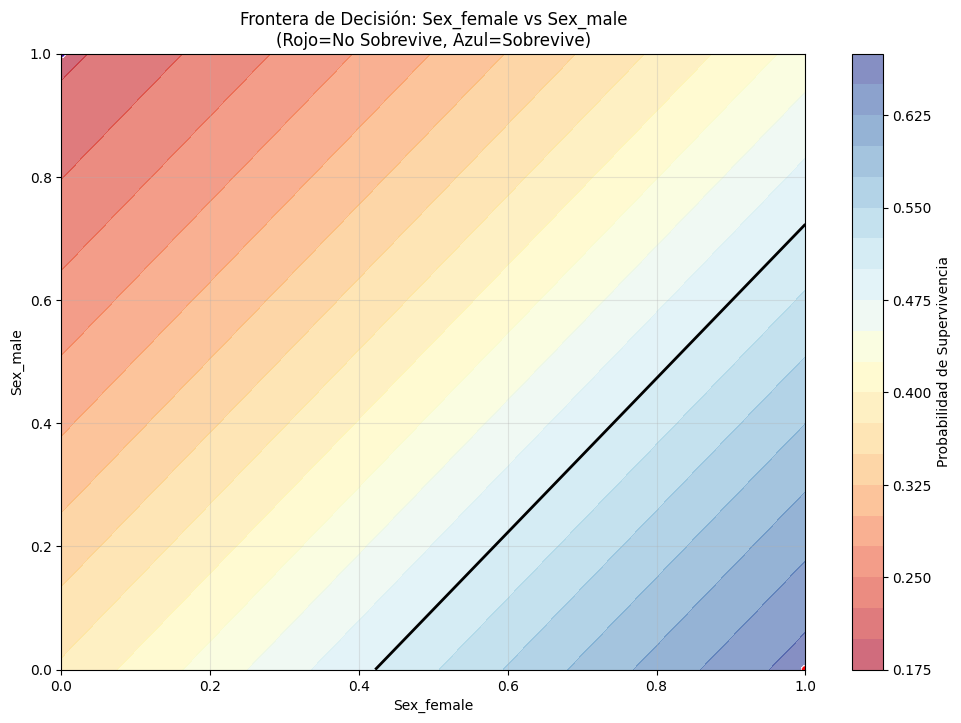

In [30]:
print("\nVISUALIZACIÓN DE FRONTERAS DE DECISIÓN")

def plot_decision_boundaries_2d(model, X_data, feature1, feature2, n_points=100):
    """Visualizar fronteras de decisión en 2D"""
    
    if feature1 not in X_data.columns or feature2 not in X_data.columns:
        print(f"Features {feature1} o {feature2} no encontradas")
        return
    
    # Crear grid de puntos
    f1_min, f1_max = X_data[feature1].quantile([0.05, 0.95])
    f2_min, f2_max = X_data[feature2].quantile([0.05, 0.95])
    
    f1_range = np.linspace(f1_min, f1_max, n_points)
    f2_range = np.linspace(f2_min, f2_max, n_points)
    f1_grid, f2_grid = np.meshgrid(f1_range, f2_range)
    
    # Crear casos para predicción usando valores medianos para otras features
    base_case = X_data.median()
    grid_cases = []
    
    for i in range(n_points):
        for j in range(n_points):
            case = base_case.copy()
            case[feature1] = f1_grid[i, j]
            case[feature2] = f2_grid[i, j]
            grid_cases.append(case)
    
    # Hacer predicciones
    grid_df = pd.DataFrame(grid_cases)
    probabilities = model.predict_proba(grid_df)[:, 1]
    prob_grid = probabilities.reshape(n_points, n_points)
    
    # Visualizar
    plt.figure(figsize=(12, 8))
    
    # Contour plot de probabilidades
    contour = plt.contourf(f1_grid, f2_grid, prob_grid, levels=20, alpha=0.6, cmap='RdYlBu')
    plt.colorbar(contour, label='Probabilidad de Supervivencia')
    
    # Línea de decisión (probabilidad = 0.5)
    plt.contour(f1_grid, f2_grid, prob_grid, levels=[0.5], colors='black', linewidths=2)
    
    # Scatter plot de datos reales
    scatter_data = X_data.sample(min(200, len(X_data)))  # Muestra para visualización
    colors = ['red' if y_test.loc[idx] == 0 else 'blue' for idx in scatter_data.index if idx in y_test.index]
    
    plt.scatter(scatter_data[feature1], scatter_data[feature2], 
               c=colors, alpha=0.7, s=30, edgecolors='white', linewidth=0.5)
    
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.title(f'Frontera de Decisión: {feature1} vs {feature2}\n(Rojo=No Sobrevive, Azul=Sobrevive)')
    plt.grid(True, alpha=0.3)
    plt.show()

# Visualizar fronteras de decisión para los 2 features más importantes
if len(top_5_features) >= 2:
    plot_decision_boundaries_2d(best_model, X_test_imputed, 
                               top_5_features[0], top_5_features[1])

## Conclusiones

Este notebook proporciona un análisis completo de interpretabilidad y explicabilidad para modelos de machine learning aplicados al dataset del Titanic. Las técnicas implementadas incluyen:

- **Feature Importance**: Análisis consolidado de la importancia de características
- **SHAP**: Análisis global y local de contribuciones de features
- **LIME**: Explicaciones locales para casos individuales
- **Partial Dependence Plots**: Visualización del efecto de features en predicciones
- **Análisis de Estabilidad**: Evaluación de la consistencia de explicaciones
- **Interacciones**: Identificación de efectos combinados entre features

El código está diseñado para ser modular y reutilizable, permitiendo aplicar las mismas técnicas a otros datasets y modelos con modificaciones mínimas.